In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import atlite
import rasterio
import pypsa
import os
import yaml
import re

import matplotlib.animation as animation

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label


preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

prefered_country_order = pd.Index(
    [
    "BN",
    "KH",
    "LA",
    "MM",
    "PH",
    "SG",
    "TH",
    "VN",
    "Peninsular/MY",
    "Sabah/MY",
    "Sarawak/MY",
    "Sumatra/ID",
    "Java-Bali/ID",
    "Kalimantan/ID",
    "Nusa-Tenggara/ID",
    "Sulawesi/ID",
    "Maluku/ID",
    "Papua/ID",
    ]
)


## Coal emission and load generation

In [34]:
def plot_emission_energy(fn, infn_energy, scenario_PyPSA, dec_name, config):

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5))
    df_all = pd.DataFrame()

    for year in fn:
        n = fn[year]
        df = pd.DataFrame(data=(n.snapshot_weightings.generators @ n.generators_t.p) / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions))
        df = df.rename(columns={0:"tCO2"})
        df["carrier"] = n.generators.carrier
        df["bus"] = n.generators.bus
        df["country"] = df.bus.map(n.buses.country)

        df2 = pd.DataFrame(data={year:df.groupby(["carrier"]).tCO2.sum()/1e6})

        if df_all.empty:
            df_all = df2
        else:
            df_all = pd.concat([df_all,df2],axis=1)

    #new_index_emission = df_all.index.intersection(preferred_order).append(df_all.index.difference(preferred_order))

    new_index_emission = ['coal-USC', 'coal-SC', 'coal-CFB', 'coal-SubC', 'coal', 'lignite', 'CCGT']

    new_columns = df_all.columns.sort_values()

    df_all.loc[new_index_emission, new_columns].T.plot(
        kind="area",
        ax=ax1,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_emission],
        rot=90,
        legend=False
    )

    #handles, labels = ax.get_legend_handles_labels()

    #handles.reverse()
    #labels.reverse()

    #ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.4), frameon=False)

    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.query("carrier != 'load'").carrier.unique()]}, index = n.generators.query("carrier != 'load'").carrier.unique())

    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()

    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))

    carrier_large = df_all.T.sum().to_frame("value").query("value > 10").index
    df_color = df_color.T[carrier_large].T
    df_color = df_color.reindex(index=df_color.index[::-1])

    #pypsa.plot.add_legend_patches(ax=ax1, colors = df_color.color, labels = df_color.index,
    #                             legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.5), 'frameon':False, 'ncol':1, 'title':"Emission Source", 
    #                                          'title_fontproperties':{'weight':'bold'}})

    ax1.set_ylabel("CO2eq Emissions [MtCO2 per year]")

    ax1.set_xlabel("")

    ax1.grid(axis="y")
    #ax1.set_ylim([0, 2000])
    ax1.set_ylim([0, 1000])
    ax1.set_xlim([2020, 2050])

    ax1.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )

    #=================================================================='###===========================================

    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()

    for year in infn_energy:
        energy_df = pd.read_csv(infn_energy[year], index_col=list(range(2)), header=[1, 2, 3])

        energy_df.columns = [year]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()

        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
    
    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    if new_index_energy.empty:
        print(f"No energy data to plot for country, no valid plot is generated")
        # create empty file to avoid issues with snakemake
        with open(infn[year], "w") as fp:
            pass
        return

    new_index_energy = ['coal-USC', 'coal-SC', 'coal-CFB', 'coal-SubC', 'coal', 'lignite', 'CCGT']

    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="area",
        ax=ax2,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90,
        legend=False
    )

    #loads_df_all.loc[:, new_columns].T.plot(
    #    kind="line",
    #    ax=ax2,
    #    color="black",
    #    linestyle = 'dashed',
    #    rot=90,
    #    legend=False
    #)

    #ax2.annotate('Load/a',
    #        xy=(2040, loads_df_all[2040]),  # theta, radius
    #        xytext=(2035, loads_df_all[2040]+1000),    # fraction, fraction
    #        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
    #        horizontalalignment='center',
    #        verticalalignment='top',
    #        )


    ax2.set_ylabel("Energy [TWh/a]")

    ax2.set_xlabel("")

    ax2.grid(axis="y")
    #ax2.set_ylim([0, 4000])
    ax2.set_ylim([0, 2000])
    ax2.set_xlim([2020,2050])

    ax2.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )

    fig.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_fossil_fuel.svg',bbox_inches='tight')

In [33]:
def add_fossil_fuel_legend(n):
    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.query("carrier != 'load'").carrier.unique()]}, index = n.generators.query("carrier != 'load'").carrier.unique())

    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()

    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))

    #carrier_large = df_all.T.sum().to_frame("value").query("value > 10").index
    #df_color = df_color.T[carrier_large].T
    df_color = df_color.loc[['coal-USC', 'coal-SC', 'coal-CFB', 'coal-SubC', 'coal', 'lignite', 'CCGT'],:]
    
    df_color = df_color.reindex(index=df_color.index[::-1])

    fig, ax = plt.subplots(figsize=(0, 0))
    ax.axis('off')

    pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"upper center",'bbox_to_anchor':(0.5, -0.15), 'frameon':False, 'ncol':7, 'title':"Components", 
                                              'title_fontproperties':{'weight':'bold'}})

    plt.savefig(f'Figures/fossil_fuel_legend.svg',bbox_inches='tight')

## Stagnant Tech Scenario

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


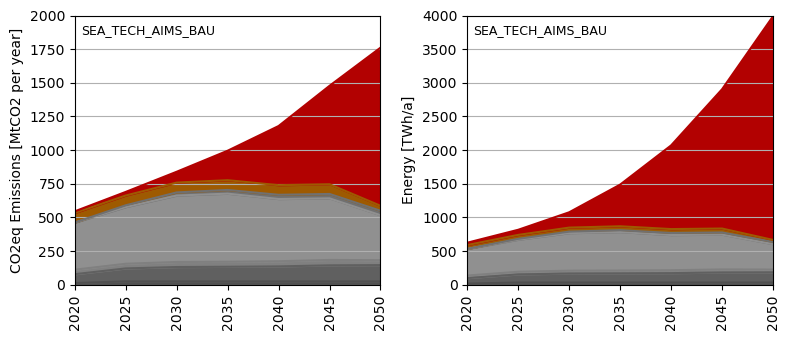

In [23]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}

scenario_PyPSA = "SEA_TECH_AIMS_"

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1.0-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.882919-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.765839-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.648758-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.531677-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.414596-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.297516-3H.nc has buses, carriers, generato

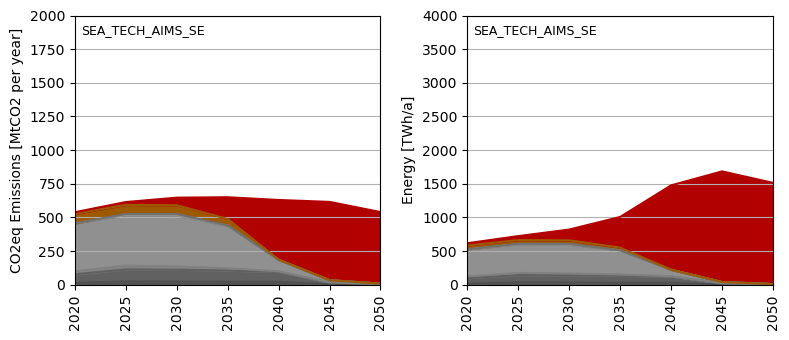

In [24]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "SE"
SE_co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
co2_share = SE_co2_share
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

scenario_PyPSA = "SEA_TECH_AIMS_"

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1.0-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750481-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.536087-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.356817-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.212671-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.103649-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.029752-3H.nc has buses, carriers, generato

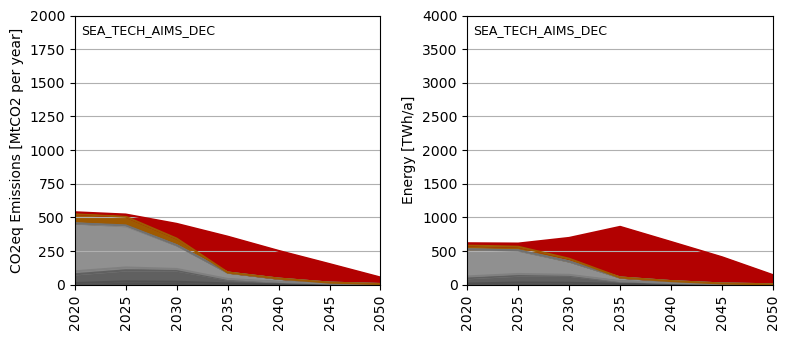

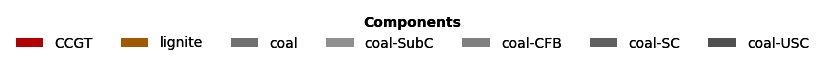

In [25]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "DEC"
DEC_co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.750481-3H",
             2030:"Co2L0.536087-3H",
             2035:"Co2L0.356817-3H",
             2040:"Co2L0.212671-3H",
             2045:"Co2L0.103649-3H",
             2050:"Co2L0.029752-3H"
            }
co2_share = DEC_co2_share
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

scenario_PyPSA = "SEA_TECH_AIMS_"

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)
add_fossil_fuel_legend(fn[2020])

## Original Scenario

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


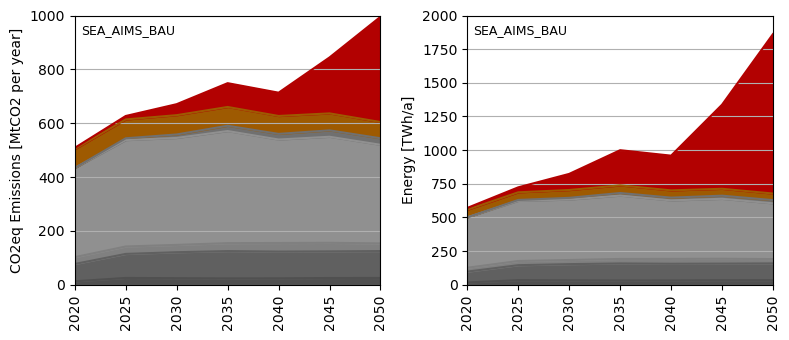

In [35]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.916821-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.833641-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750462-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.584104-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators

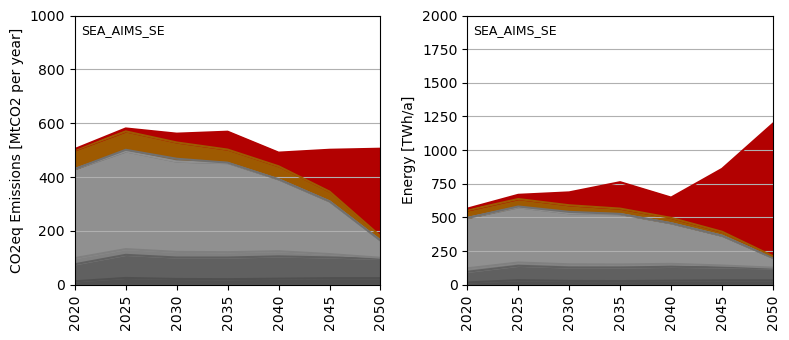

In [36]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "SE"
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
co2_share = SE_co2_share
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

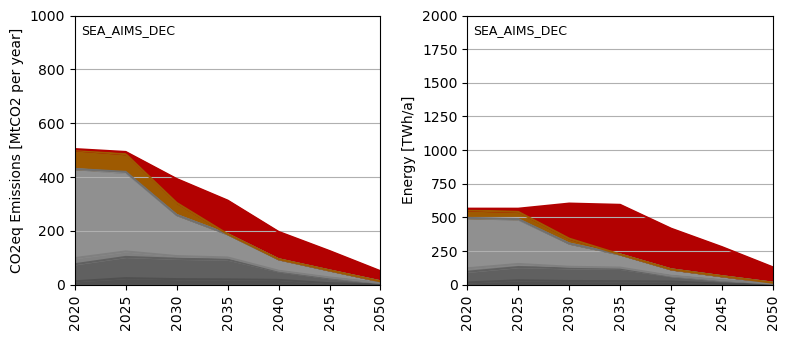

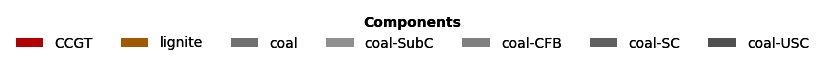

In [37]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "DEC"
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }
co2_share = DEC_co2_share
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

df = plot_emission_energy(fn, scenario_infn_energy, scenario_PyPSA, dec_name, config)
add_fossil_fuel_legend(fn[2020])

## Derriving the Decarbonization Policy Target

In [4]:
def check_emission_year(fn, scenario_PyPSA, dec_name):

    df_all = pd.DataFrame()

    for n in fn:
        df = pd.DataFrame(data=(n.snapshot_weightings.generators @ n.generators_t.p) / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions))
        df = df.rename(columns={0:"tCO2"})
        df["carrier"] = n.generators.carrier
        df["bus"] = n.generators.bus
        df["country"] = df.bus.map(n.buses.country)

        df2 = pd.DataFrame(data={fn[n]:df.groupby(["carrier"]).tCO2.sum()/1e6})

        if df_all.empty:
            df_all = df2
        else:
            df_all = pd.concat([df_all,df2],axis=1)

    new_index_emission = df_all.index.intersection(preferred_order).append(df_all.index.difference(preferred_order))

    new_columns = df_all.columns.sort_values()

    fig_emission, ax = plt.subplots()
    fig_emission.set_size_inches((6, 3))

    df_all.loc[new_index_emission, new_columns].T.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_emission],
        rot=90
    )

    #handles, labels = ax.get_legend_handles_labels()

    #handles.reverse()
    #labels.reverse()

    #ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.4), frameon=False)

    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.query("carrier != 'load'").carrier.unique()]}, index = n.generators.query("carrier != 'load'").carrier.unique())

    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()

    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))

    carrier_large = df_all.T.sum().to_frame("value").query("value > 10").index
    df_color = df_color.T[carrier_large].T
    df_color = df_color.reindex(index=df_color.index[::-1])

    pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.5), 'frameon':False, 'ncol':1, 'title':"Emission Source", 
                                              'title_fontproperties':{'weight':'bold'}})

    ax.set_ylabel("CO2eq Emissions [MtCO2 per year]")

    ax.set_xlabel("")

    ax.grid(axis="y")
    ax.set_ylim([0, 1200])
    ax.set_xlim([2020, 2050])

    #ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    fig_emission.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_emission.svg',bbox_inches='tight')

    return df_all
    

In [5]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"#-preliminary-results_V3"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_bau = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


Total emission is 25573.253442769983


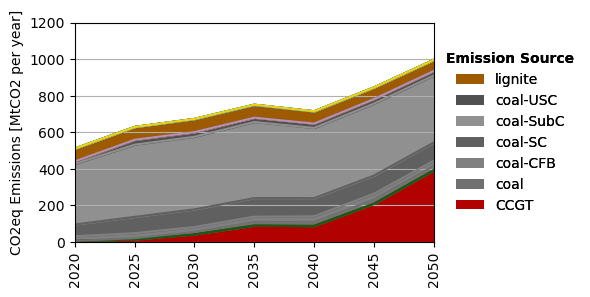

In [6]:
df_emission_bau = check_emission_year({v: k for k, v in fn_bau.items()},scenario_PyPSA,dec_name)
total_emission = 0
for year in years:
    total_emission += df_emission_bau.loc[:,year].sum() * 5
print(f"Total emission is {total_emission}")

In [7]:
scenario_PyPSA = "SEA_EXIST_"
#folder_name = "pypsa-earth"
#network_name = "elec_s_200_ec_lcopt_3H"

#years = [2020,2025,2030,2050]

fn_int = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


Total emission is 26947.4644074236


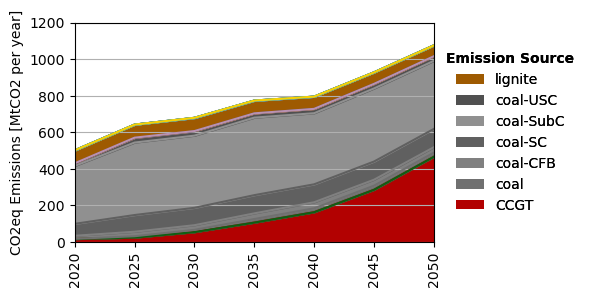

In [8]:
df_emission_int = check_emission_year({v: k for k, v in fn_int.items()},scenario_PyPSA,dec_name)
total_emission = 0
for year in years:
    total_emission += df_emission_int.loc[:,year].sum() * 5
print(f"Total emission is {total_emission}")

In [9]:
year = 2050
n = fn_int[year]
df_emission_int[year].sum() * 1e6 / (n.snapshot_weightings.generators @ n.loads_t.p_set).sum()

0.16756566468891165

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


Total emission is 25140.824659981336


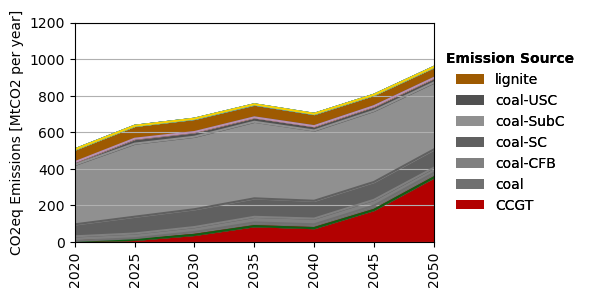

In [10]:
scenario_PyPSA = "SEA_IRENA_"
#folder_name = "pypsa-earth"
#network_name = "elec_s_200_ec_lcopt_3H"

#years = [2020,2025,2030,2035]

fn_ext = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

df_emission_ext = check_emission_year({v: k for k, v in fn_ext.items()},scenario_PyPSA,dec_name)
total_emission = 0
for year in years:
    total_emission += df_emission_ext.loc[:,year].sum() * 5
print(f"Total emission is {total_emission}")

In [22]:
df = pd.DataFrame(data={"bau":df_emission_bau.sum()*1e6,"int":df_emission_int.sum()*1e6,"ext":df_emission_ext.sum()*1e6})
df["average"] = (df["bau"] + df["int"] + df["ext"])/3

df.loc[2020,"compare_2020"] = 1.0
df.loc[2050,"compare_2020"] = df.loc[2020,"average"]/df.loc[2050,"average"]
df.loc[:,"compare_2020"] = df.loc[:,"compare_2020"].infer_objects(copy=False).interpolate(method='linear')

df.loc[2020,"target_2050"] = 1.0
df.loc[2050,"target_2050"] = 0.1
df.loc[:,"target_2050"] = df.loc[:,"target_2050"].infer_objects(copy=False).interpolate(method='linear')

df["refactor"] = df["compare_2020"] * df["target_2050"]
df["decarb_target"] = df["average"] * df["refactor"]

In [23]:
df

,bau,int,ext,average,compare_2020,target_2050,refactor,decarb_target
2020,5.098593e+08,5.006786e+08,5.055491e+08,5.053623e+08,1.000000,1.00,1.000000,5.053623e+08
2025,6.281947e+08,6.412769e+08,6.347996e+08,6.347571e+08,0.916821,0.85,0.779298,4.946647e+08
2030,6.723646e+08,6.785117e+08,6.737135e+08,6.748633e+08,0.833641,0.70,0.583549,3.938158e+08
2035,7.502342e+08,7.728619e+08,7.524176e+08,7.585046e+08,0.750462,0.55,0.412754,3.130760e+08
2040,7.142214e+08,7.944080e+08,7.003488e+08,7.363261e+08,0.667283,0.40,0.266913,1.965351e+08
2045,8.445214e+08,9.270585e+08,8.047103e+08,8.587634e+08,0.584104,0.25,0.146026,1.254017e+08
2050,9.952550e+08,1.074697e+09,9.566261e+08,1.008859e+09,0.500924,0.10,0.050092,5.053623e+07


In [31]:
fn_int[2050].statistics().groupby("carrier").sum()["Curtailment"].sum()

98785606.89424673

In [32]:
fn_ext[2050].statistics().groupby("carrier").sum()["Curtailment"].sum()

100448428.30420913

In [33]:
(9.952550e+08 - 1.074697e+09) / 1.074697e+09

-0.07392037011362272

<AxesSubplot:>

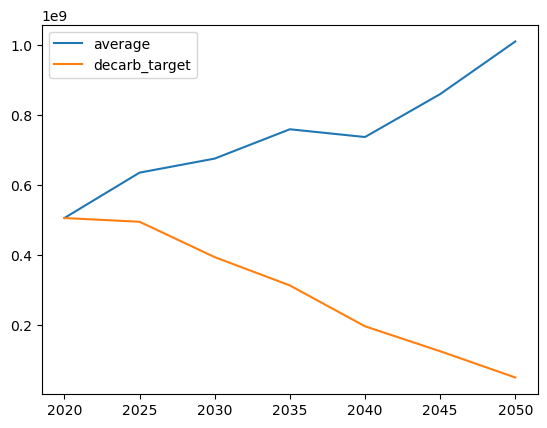

In [15]:
df.loc[:,["average","decarb_target"]].plot()

<AxesSubplot:>

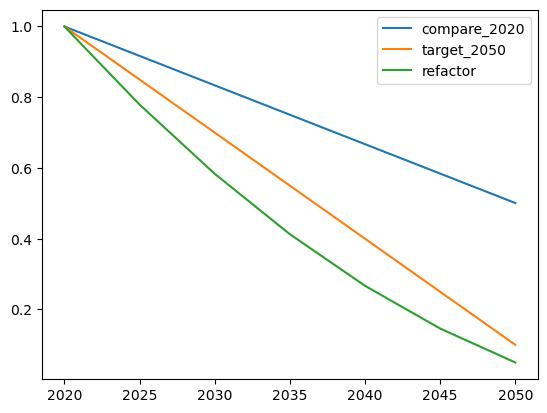

In [16]:
df.loc[:,["compare_2020","target_2050","refactor"]].plot()

In [27]:
df = pd.DataFrame(data={"bau":df_emission_bau.sum()*1e6,"int":df_emission_int.sum()*1e6,"ext":df_emission_ext.sum()*1e6})
df["average"] = (df["bau"] + df["int"] + df["ext"])/3

df.loc[2020,"compare_2020"] = 1.0
df.loc[2050,"compare_2020"] = df.loc[2020,"average"]/df.loc[2050,"average"]
df.loc[:,"compare_2020"] = df.loc[:,"compare_2020"].infer_objects(copy=False).interpolate(method='linear')

df.loc[2020,"target_2050"] = 1.0
df.loc[2050,"target_2050"] = 1.0
df.loc[:,"target_2050"] = df.loc[:,"target_2050"].infer_objects(copy=False).interpolate(method='linear')

df["refactor"] = df["compare_2020"] * df["target_2050"]
df["decarb_target"] = df["average"] * df["refactor"]

In [28]:
df

,bau,int,ext,average,compare_2020,target_2050,refactor,decarb_target
2020,5.098402e+08,5.006746e+08,5.055492e+08,5.053547e+08,1.000000,1.0,1.000000,5.053547e+08
2025,6.281836e+08,6.412603e+08,6.348006e+08,6.347482e+08,0.916561,1.0,0.916561,5.817852e+08
2030,6.724725e+08,6.792364e+08,6.736002e+08,6.751030e+08,0.833121,1.0,0.833121,5.624427e+08
2035,7.512653e+08,7.739852e+08,7.532213e+08,7.594906e+08,0.749682,1.0,0.749682,5.693764e+08
2040,7.149332e+08,7.947193e+08,6.994388e+08,7.363638e+08,0.666243,1.0,0.666243,4.905969e+08
2045,8.360455e+08,9.252822e+08,8.010051e+08,8.541109e+08,0.582803,1.0,0.582803,4.977786e+08
2050,1.005262e+09,1.072904e+09,9.578251e+08,1.011997e+09,0.499364,1.0,0.499364,5.053547e+08


<AxesSubplot:>

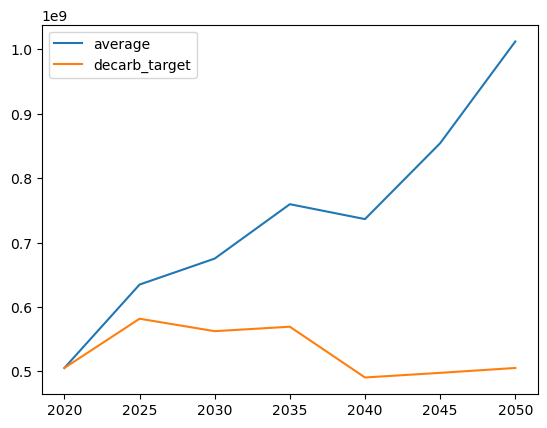

In [29]:
df.loc[:,["average","decarb_target"]].plot()

<AxesSubplot:>

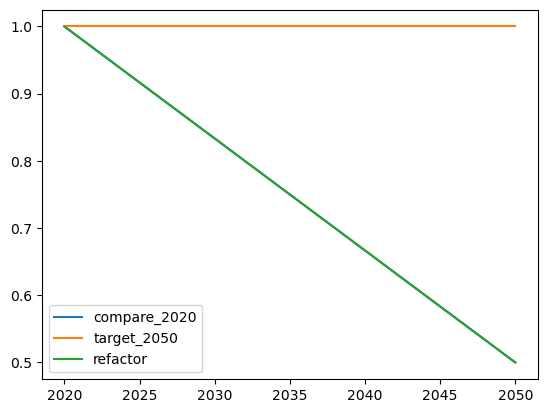

In [30]:
df.loc[:,["compare_2020","target_2050","refactor"]].plot()

In [110]:
scenario_PyPSA = "SEA_AEO8_AIMS_"
folder_name = "pypsa-earth"#-preliminary-results_V3"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

years = [2025,2030,2035,2040,2045,2050]

fn_aeo8 = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}
fn_aeo8[2020] = pypsa.Network(f"../{folder_name}/results/SEA_AIMS_2020/networks/{network_name}.nc")

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


Total emission is 21120.27215184303


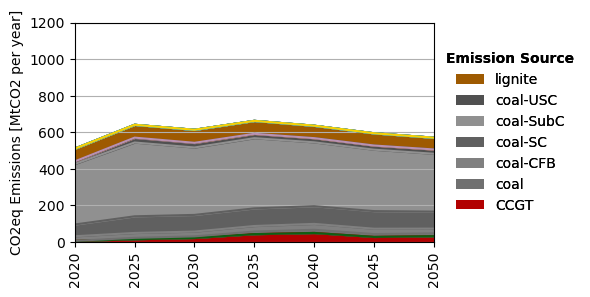

In [111]:
years = [2020,2025,2030,2035,2040,2045,2050]

df_emission_aeo8 = check_emission_year({v: k for k, v in fn_aeo8.items()},scenario_PyPSA,dec_name)
total_emission = 0
for year in years:
    total_emission += df_emission_aeo8.loc[:,year].sum() * 5
print(f"Total emission is {total_emission}")

In [114]:
for year in years:
    print(fn_aeo8[year].loads_t.p_set.sum().sum() * 3)

1103240000.0
1412600000.0
1664900000.0000002
1953400000.0
2358800000.0
2920600000.0
3528100000.0


,2020,2025,2030,2035,2040,2045,2050
carrier,,,,,,,
CCGT,4.658208,14.469648,21.221278,42.071213,48.358105,26.831861,30.865152
biomass,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
coal,0.292830,7.043197,8.408091,13.933839,17.213326,15.506451,15.188699
coal-CFB,25.286495,26.884511,26.199805,30.360778,32.395228,29.182733,25.967797
coal-SC,64.325507,91.007691,91.255380,96.457386,96.895378,96.344365,93.083268
coal-SubC,331.031596,403.847877,368.909928,384.238766,349.413121,336.123878,316.623645
coal-USC,12.967713,25.398916,24.610999,23.540936,22.897717,22.854327,23.445335
geothermal,1.360600,1.357098,0.968148,0.211136,NaN,NaN,NaN
lignite,69.933459,70.349063,71.022180,70.948930,67.698731,66.843049,64.438045


In [119]:
df = pd.DataFrame(data={"average":df_emission_aeo8[years].sum()*1e6})

df.loc[2020,"compare_2020"] = 1.0
df.loc[2050,"compare_2020"] = df.loc[2020,"average"]/df.loc[2050,"average"]
df.loc[:,"compare_2020"] = df.loc[:,"compare_2020"].infer_objects(copy=False).interpolate(method='linear')

df.loc[2020,"target_2050"] = 1.0
df.loc[2050,"target_2050"] = 0.1
df.loc[:,"target_2050"] = df.loc[:,"target_2050"].infer_objects(copy=False).interpolate(method='linear')

df["refactor"] = df["compare_2020"] * df["target_2050"]
df["decarb_target"] = df["average"] * df["refactor"]

In [120]:
df

,average,compare_2020,target_2050,refactor,decarb_target
2020,5.098593e+08,1.000000,1.00,1.000000,5.098593e+08
2025,6.403623e+08,0.982516,0.85,0.835138,5.347911e+08
2030,6.130273e+08,0.965031,0.70,0.675522,4.141134e+08
2035,6.619141e+08,0.947547,0.55,0.521151,3.449572e+08
2040,6.353604e+08,0.930063,0.40,0.372025,2.363701e+08
2045,5.939158e+08,0.912579,0.25,0.228145,1.354987e+08
2050,5.696151e+08,0.895094,0.10,0.089509,5.098593e+07


## SE and DEC results

In [15]:
scenario_PyPSA = "SEA_opt_BAU_"
folder_name = "pypsa-earth"
co2_share_stable = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
co2_share_dec = {2020:"Co2L1.0-3H",
             2025:"Co2L0.750481-3H",
             2030:"Co2L0.536087-3H",
             2035:"Co2L0.356817-3H",
             2040:"Co2L0.212671-3H",
             2045:"Co2L0.103649-3H",
             2050:"Co2L0.029752-3H"
            }

co2_share = co2_share_stable
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1.0-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.882919-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.765839-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.648758-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.531677-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.414596-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.297516-3H.nc has buses, carriers, generato

Total emission is 7501.883361336352


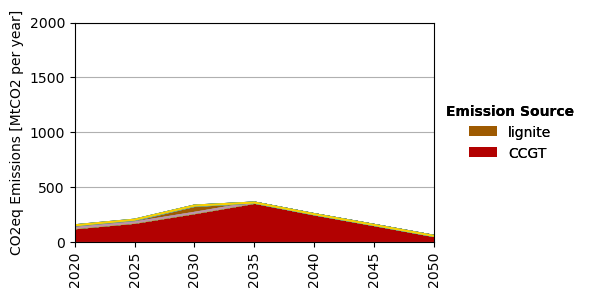

In [14]:
df_emission_bau = check_emission_year({v: k for k, v in fn.items()},"PyPSA-SEA_No_limits",network_name)
total_emission = 0
for year in years:
    total_emission += df_emission_bau.loc[:,year].sum() * 5
print(f"Total emission is {total_emission}")